<a href="https://colab.research.google.com/github/HireTheHero/Machine_Notebooks/blob/main/multimodal2image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# notebook for testing image+text->image
## Operational
- [GILL](https://github.com/evelynmitchell/gill/blob/main/README.md)

## TBD
- [CM3Leon](https://github.com/kyegomez/CM3Leon/blob/main/README.md)

# init

## env setup

### CM3Leon

In [1]:
# CM3Leon
!pip install cm3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.3/867.3 kB 70.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 112.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.0/134.0 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 36.7 MB/s eta

In [2]:
# !pip install -U einops
!pip install einops==0.6.1

In [3]:
!pip install -U torch torchvision torchaudio

### GILL

In [5]:
# GILL
# %cd /content
%rm -rf /content/gill
!git clone https://github.com/kohjingyu/gill.git
!cd gill; pip install --no-deps -r requirements.txt
# !cd gill; pip install -r requirements.txt
!pip install numpy==1.23.5

Cloning into 'gill'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 209 (delta 37), reused 30 (delta 23), pack-reused 148
Receiving objects: 100% (209/209), 89.89 MiB | 14.73 MiB/s, done.
Resolving deltas: 100% (113/113), done.
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-iijra0cw
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-iijra0cw
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
ERROR: pip's dependency resolver do

In [2]:
!echo $PYTHONPATH
!export PYTHONPATH=$PYTHONPATH:/content/gill/gill/

/env/python


## code modification

In [2]:
%%writefile /content/gill/gill/models.py
from typing import List, Optional
from collections import namedtuple
from diffusers import StableDiffusionPipeline
import json
import numpy as np
import os
import glob
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
from PIL import Image, UnidentifiedImageError
from requests.exceptions import ConnectionError

from transformers import AutoTokenizer, AutoModel, CLIPVisionModel, OPTForCausalLM
from gill.gill import utils
from gill.gill import layers


class GILLArgs:
  freeze_lm: bool = True
  freeze_vm: bool = True
  opt_version: str = 'facebook/opt-6.7b'
  visual_encoder: str = 'openai/clip-vit-large-patch14'
  n_visual_tokens: int = 1
  task: str = 'captioning'
  ret_emb_dim: Optional[int] = 256
  gen_emb_dim: Optional[int] = 256
  text_emb_layers: List[int] = [-1]
  gen_token_idx: List[int] = [0]
  retrieval_token_idx: List[int] = [0]
  text_fc_mode: str = 'gill_mapper'
  ret_text_fc_mode: str = 'linear'
  num_tokens: int = 8
  num_clip_tokens: int = 77


class GILLModel(nn.Module):
  def __init__(self, tokenizer, args: GILLArgs = GILLArgs()):
    super().__init__()
    self.tokenizer = tokenizer
    self.feature_extractor = utils.get_feature_extractor_for_model(args.visual_encoder, train=False)
    self.image_token = self.tokenizer.cls_token_id
    assert args.text_emb_layers != set(args.text_emb_layers), 'text_emb_layers not unique'
    self.args = args
    self.num_tokens = args.num_tokens
    self.num_clip_tokens = args.num_clip_tokens

    opt_version = args.opt_version
    visual_encoder = args.visual_encoder
    n_visual_tokens = args.n_visual_tokens
    print(f"Using {opt_version} for the language model.")
    print(f"Using {visual_encoder} for the visual model with {n_visual_tokens} visual tokens.")

    if 'facebook/opt' in opt_version:
      self.lm = OPTForCausalLM.from_pretrained(opt_version)
    else:
      raise NotImplementedError

    self.opt_version = opt_version

    if self.args.freeze_lm:
      self.lm.eval()
      print("Freezing the LM.")
      for param in self.lm.parameters():
        param.requires_grad = False
    else:
      self.lm.train()

    self.retrieval_token_idx = args.retrieval_token_idx
    self.gen_token_idx = args.gen_token_idx
    self.lm.resize_token_embeddings(len(tokenizer))

    self.input_embeddings = self.lm.get_input_embeddings()

    print("Restoring pretrained weights for the visual model.")
    if 'clip' in visual_encoder:
      self.visual_model = CLIPVisionModel.from_pretrained(visual_encoder)
    else:
      self.visual_model = AutoModel.from_pretrained(visual_encoder)

    if 'clip' in visual_encoder:
      hidden_size = self.visual_model.config.hidden_size
    else:
      raise NotImplementedError

    if self.args.freeze_vm:
      print("Freezing the VM.")
      self.visual_model.eval()
      for param in self.visual_model.parameters():
        param.requires_grad = False
    else:
      self.visual_model.train()

    self.visual_model_name = visual_encoder

    embedding_dim = self.input_embeddings.embedding_dim * self.args.n_visual_tokens
    self.ret_text_hidden_fcs = nn.ModuleList([])
    self.gen_text_hidden_fcs = nn.ModuleList([])

    for layer_idx in self.args.text_emb_layers:
      if (layer_idx == -1 or layer_idx == self.lm.config.num_hidden_layers) and ('bert' not in opt_version):
        if 'opt' in opt_version:  # OPT models
          in_dim = self.lm.config.word_embed_proj_dim
        else:
          raise NotImplementedError

        self.ret_text_hidden_fcs.append(
          layers.TextFcLayer(in_dim, self.args.ret_emb_dim, num_input_tokens=self.args.num_tokens,
                             num_output_tokens=1, mode=self.args.ret_text_fc_mode))
        self.gen_text_hidden_fcs.append(
          layers.TextFcLayer(in_dim, self.args.gen_emb_dim, num_input_tokens=self.args.num_tokens,
                             num_output_tokens=self.args.num_clip_tokens, mode=self.args.text_fc_mode))

      elif layer_idx < self.lm.config.num_hidden_layers:
        self.ret_text_hidden_fcs.append(layers.TextFcLayer(self.lm.config.hidden_size, self.args.ret_emb_dim, num_input_tokens=self.args.num_tokens, num_output_tokens=1, mode=self.args.ret_text_fc_mode))
        self.gen_text_hidden_fcs.append(layers.TextFcLayer(self.lm.config.hidden_size, self.args.gen_emb_dim, num_input_tokens=self.args.num_tokens, num_output_tokens=self.args.num_clip_tokens, mode=self.args.text_fc_mode))
      else:
        raise ValueError(f'Embedding of layer {layer_idx} was requested but model only has {self.lm.config.num_hidden_layers} layers.')

    self.visual_embeddings = nn.Linear(hidden_size, embedding_dim)

    # Retrieval image FC layer.
    self.visual_fc = nn.Linear(hidden_size, self.args.ret_emb_dim)
    self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))


  def get_visual_embs(self, pixel_values: torch.FloatTensor, mode: str = 'captioning'):
    if mode not in ['captioning', 'retrieval', 'generation']:
      raise ValueError(f"mode should be one of ['captioning', 'retrieval', 'generation'], got {mode} instead.")

    # Extract visual embeddings from the vision encoder.
    if 'clip' in self.visual_model_name:
      outputs = self.visual_model(pixel_values)
      encoder_outputs = outputs.pooler_output
    else:
      raise NotImplementedError

    # Use the correct fc based on function argument.
    if mode == 'captioning':
      visual_embs = self.visual_embeddings(encoder_outputs)  # (2, D * n_visual_tokens)
      visual_embs = torch.reshape(visual_embs, (visual_embs.shape[0], self.args.n_visual_tokens, -1))
    elif mode == 'retrieval':
      visual_embs = self.visual_fc(encoder_outputs)  # (2, D * n_visual_tokens)
      visual_embs = torch.reshape(visual_embs, (visual_embs.shape[0], 1, -1))
    elif mode == 'generation':
      visual_embs = torch.zeros((pixel_values.shape[0], 1, 768), device=pixel_values.device)
    else:
      raise NotImplementedError

    return visual_embs


  def train(self, mode=True):
    super(GILLModel, self).train(mode=mode)
    # Overwrite train() to ensure frozen models remain frozen.
    if self.args.freeze_lm:
      self.lm.eval()
    if self.args.freeze_vm:
      self.visual_model.eval()


  def forward(
    self,
    pixel_values: torch.FloatTensor,
    labels: Optional[torch.LongTensor] = None,
    caption_len: Optional[torch.LongTensor] = None,
    mode: str = 'captioning',
    concat_captions: bool = False,
    input_prefix: Optional[str] = None,
  ):
    visual_embs = self.get_visual_embs(pixel_values, mode)

    batch_size, vis_seq_len, _ = visual_embs.shape  # vis_seq_len = n_visual_tokens
    if labels is not None:
      assert labels.shape[0] == batch_size, (visual_embs.shape, labels.shape)
    visual_embs_norm = ((visual_embs ** 2).sum(dim=-1) ** 0.5).mean()

    input_embs = self.input_embeddings(labels)  # (N, T, D)
    input_embs_norm = ((input_embs ** 2).sum(dim=-1) ** 0.5).mean()

    last_embedding_idx = caption_len - 1  # -1 to retrieve the token before the eos token

    if input_prefix is not None:
      prompt_ids = self.tokenizer(input_prefix, add_special_tokens=False, return_tensors="pt").input_ids
      prompt_ids = prompt_ids.to(visual_embs.device)
      prompt_embs = self.input_embeddings(prompt_ids)
      prompt_embs = prompt_embs.repeat(batch_size, 1, 1)
      assert prompt_embs.shape[0] == batch_size, prompt_embs.shape
      assert prompt_embs.shape[2] == input_embs.shape[2], prompt_embs.shape
      assert len(prompt_embs.shape) == 3, prompt_embs.shape

    if mode == 'captioning':
      # Concat to text embeddings.
      condition_seq_len = 0
      if input_prefix is None:
        # Just add visual embeddings.
        input_embs = torch.cat([visual_embs, input_embs], axis=1)
        last_embedding_idx += vis_seq_len
        condition_seq_len += vis_seq_len
        full_labels = torch.zeros(visual_embs.shape[:2], dtype=torch.int64).to(visual_embs.device) - 100
      else:
        print(f'Adding prefix "{input_prefix}" to captioning.')
        # Add visual and prompt embeddings.
        prefix_embs = torch.cat([visual_embs, prompt_embs], axis=1)
        input_embs = torch.cat([prefix_embs, input_embs], axis=1)

        last_embedding_idx += prefix_embs.shape[1]
        condition_seq_len += prefix_embs.shape[1]
        full_labels = torch.zeros(prefix_embs.shape[:2], dtype=torch.int64).to(visual_embs.device) - 100

      # Mask out embedding tokens in the labels.
      full_labels = torch.cat([full_labels, labels], axis=1)

      pad_idx = []

      for label in full_labels:
        for k, token in enumerate(label):
          # Mask out retrieval/gen tokens if they exist.
          if token in [self.tokenizer.pad_token_id] + self.retrieval_token_idx + self.gen_token_idx:
            label[k:] = -100
            pad_idx.append(k)
            break
          if k == len(label) - 1:  # No padding found.
            pad_idx.append(k + 1)
      assert len(pad_idx) == batch_size, (len(pad_idx), batch_size)

      bs, seq_len, embs_dim = input_embs.shape
      if concat_captions:
        print('Concatenating examples for captioning!')
        assert len(input_embs.shape) == 3, input_embs
        assert len(full_labels.shape) == 2, full_labels
        assert batch_size % 2 == 0
        all_concat_input_embs = []
        all_concat_labels = []

        # Rearrange embeddings and labels (and their padding) to concatenate captions.
        for i in range(batch_size // 2):
          first_idx = i * 2
          second_idx = first_idx + 1
          first_emb = input_embs[first_idx, :pad_idx[first_idx], :]
          first_labels = full_labels[first_idx, :pad_idx[first_idx]]
          first_padding = input_embs[first_idx, pad_idx[first_idx]:, :]
          first_labels_padding = full_labels[first_idx, pad_idx[first_idx]:]

          second_emb = input_embs[second_idx, :pad_idx[second_idx], :]
          second_labels = full_labels[second_idx, :pad_idx[second_idx]]
          second_padding = input_embs[second_idx, pad_idx[second_idx]:, :]
          second_labels_padding = full_labels[second_idx, pad_idx[second_idx]:]
          bos_idx = visual_embs.shape[1]

          assert torch.all(first_labels_padding == -100), first_labels_padding
          assert torch.all(second_labels_padding == -100), second_labels_padding
          assert torch.all(second_labels[bos_idx] == self.tokenizer.bos_token_id), (second_labels, bos_idx, self.tokenizer.bos_token_id)

          # Remove BOS token of the second caption.
          second_labels = torch.cat([second_labels[:bos_idx], second_labels[bos_idx + 1:]], axis=0)
          second_emb = torch.cat([second_emb[:bos_idx, :], second_emb[bos_idx + 1:, :]], axis=0)

          concat_input_embs = torch.cat([first_emb, second_emb, first_padding, second_padding], axis=0)   # (T*2, 768)
          concat_labels = torch.cat([first_labels, second_labels, first_labels_padding, second_labels_padding], axis=0)   # (T*2, 768)
          all_concat_input_embs.append(concat_input_embs)
          all_concat_labels.append(concat_labels)

        # Pad to max length.
        input_embs = torch.stack(all_concat_input_embs, axis=0)  # (N/2, T*2, 768)
        full_labels = torch.stack(all_concat_labels, axis=0)  # (N/2, T*2, 768)
        print("Concatenated full_labels:", full_labels[0, ...])
        assert input_embs.shape == (bs // 2, seq_len * 2 - 1, embs_dim), input_embs.shape
        assert full_labels.shape == (bs // 2, seq_len * 2 - 1), full_labels.shape

      output = self.lm(inputs_embeds=input_embs,
                       labels=full_labels,
                       output_hidden_states=True)
    elif mode in ['retrieval', 'generation']:
      full_labels = torch.clone(labels)
      if input_prefix is not None:
        print(f'Adding prefix "{input_prefix}" to retrieval.')
        # Add prompt embeddings.
        prefix_embs = prompt_embs
        input_embs = torch.cat([prefix_embs, input_embs], axis=1)
        last_embedding_idx += prefix_embs.shape[1]
        full_labels = torch.cat([
          torch.zeros(prefix_embs.shape[:2], dtype=torch.int64).to(labels.device) - 100,
          full_labels
        ], axis=1)

      pad_idx = []
      for label in full_labels:
        for k, token in enumerate(label):
          if (token == self.tokenizer.pad_token_id):
            label[k:] = -100
            pad_idx.append(k)
            break
          if k == len(label) - 1:  # No padding found.
            pad_idx.append(k + 1)
      assert len(pad_idx) == batch_size, (len(pad_idx), batch_size)

      bs, seq_len, embs_dim = input_embs.shape
      # Concatenate examples for captioning, if specified.
      if concat_captions:
        print(f'Concatenating examples for {mode}!')
        assert len(input_embs.shape) == 3, input_embs
        assert len(full_labels.shape) == 2, full_labels
        assert batch_size % 2 == 0
        all_concat_input_embs = []
        all_concat_labels = []
        all_last_embedding_idx = []

        # Rearrange embeddings and labels (and their padding) to concatenate captions.
        for i in range(batch_size // 2):
          first_idx = i * 2
          second_idx = first_idx + 1
          first_emb = input_embs[first_idx, :pad_idx[first_idx], :]
          first_labels = full_labels[first_idx, :pad_idx[first_idx]]
          first_padding = input_embs[first_idx, pad_idx[first_idx]:, :]
          first_labels_padding = full_labels[first_idx, pad_idx[first_idx]:]

          second_emb = input_embs[second_idx, :pad_idx[second_idx], :]
          second_labels = full_labels[second_idx, :pad_idx[second_idx]]
          second_padding = input_embs[second_idx, pad_idx[second_idx]:, :]
          second_labels_padding = full_labels[second_idx, pad_idx[second_idx]:]

          bos_idx = 0
          assert torch.all(first_labels_padding == -100), first_labels_padding
          assert torch.all(second_labels_padding == -100), second_labels_padding
          assert torch.all(second_labels[bos_idx] == self.tokenizer.bos_token_id), (second_labels, bos_idx, self.tokenizer.bos_token_id)

          # Remove BOS token of second caption.
          second_labels = second_labels[bos_idx + 1:]
          second_emb = second_emb[bos_idx + 1:, :]
          last_embedding_idx[second_idx] = last_embedding_idx[second_idx] - 1

          concat_input_embs = torch.cat([first_emb, second_emb, first_padding, second_padding], axis=0)   # (T*2, 768)
          concat_labels = torch.cat([first_labels, second_labels, first_labels_padding, second_labels_padding], axis=0)   # (T*2, 768)
          all_concat_input_embs.append(concat_input_embs)
          all_concat_labels.append(concat_labels)

          all_last_embedding_idx.append((last_embedding_idx[first_idx], first_emb.shape[0] + last_embedding_idx[second_idx]))

          if mode == 'retrieval':
            assert concat_labels[all_last_embedding_idx[-1][0]] in self.retrieval_token_idx, (concat_labels, all_last_embedding_idx[-1][0])
            assert concat_labels[all_last_embedding_idx[-1][1]] in self.retrieval_token_idx, (concat_labels, all_last_embedding_idx[-1][1])
          elif mode == 'generation':
            # Check that the last n tokens are GEN tokens.
            for gen_i in range(len(self.gen_token_idx)):
              assert concat_labels[all_last_embedding_idx[-1][0]-gen_i] == self.gen_token_idx[-gen_i-1], (concat_labels, all_last_embedding_idx[-1][0]-gen_i, self.gen_token_idx[-gen_i-1])
              assert concat_labels[all_last_embedding_idx[-1][1]-gen_i] == self.gen_token_idx[-gen_i-1], (concat_labels, all_last_embedding_idx[-1][1]-gen_i, self.gen_token_idx[-gen_i-1])

        # Pad to max length.
        input_embs = torch.stack(all_concat_input_embs, axis=0)  # (N/2, T*2, 768)
        full_labels = torch.stack(all_concat_labels, axis=0)  # (N/2, T*2, 768)
        assert input_embs.shape == (bs // 2, seq_len * 2 - 1, embs_dim), input_embs.shape
        assert full_labels.shape == (bs // 2, seq_len * 2 - 1), full_labels.shape

      # Update labels to pad non-first tokens.
      for label in full_labels:
        for k, token in enumerate(label):
          if (token == self.tokenizer.pad_token_id) or (token in (self.retrieval_token_idx[1:] + self.gen_token_idx[1:])):
            label[k:] = -100
            break
      output = self.lm(inputs_embeds=input_embs,
                       labels=full_labels,
                       output_hidden_states=True)
    else:
      raise NotImplementedError

    last_embedding = None
    last_output_logit = None
    hidden_states = []
    llm_hidden_states = []

    if mode in ['retrieval', 'generation']:
      num_tokens = self.num_tokens
      if mode == 'retrieval':
        text_hidden_fcs = self.ret_text_hidden_fcs
      else:
        text_hidden_fcs = self.gen_text_hidden_fcs

      # Concatenate captions for retrieval / generation, if specified.
      if not concat_captions:
        for idx, fc_layer in zip(self.args.text_emb_layers, text_hidden_fcs):
          input_hidden_state = torch.stack([output.hidden_states[idx][i, last_embedding_idx[i]-num_tokens+1:last_embedding_idx[i]+1, :] for i in range(batch_size)], axis=0)
          input_embedding = torch.stack([input_embs[i, last_embedding_idx[i]-num_tokens+1:last_embedding_idx[i]+1, :] for i in range(batch_size)], axis=0)
          llm_hidden_states.append(input_hidden_state)
          hidden_states.append(fc_layer(input_hidden_state, input_embedding))  # (N, seq_len, 2048)
      else:
        for idx, fc_layer in zip(self.args.text_emb_layers, text_hidden_fcs):
          all_last_embedding = []
          all_input_embedding = []
          all_last_output_logit = []
          for i in range(batch_size // 2):
            first_last_embedding_idx, second_last_embedding_idx = all_last_embedding_idx[i]
            first_last_embedding = output.hidden_states[idx][i, first_last_embedding_idx-num_tokens+1:first_last_embedding_idx+1, :]  # (N, D)
            second_last_embedding = output.hidden_states[idx][i, second_last_embedding_idx-num_tokens+1:second_last_embedding_idx+1, :]  # (N, D)
            all_last_embedding.append(first_last_embedding)
            all_last_embedding.append(second_last_embedding)

            first_input_embs = input_embs[i, first_last_embedding_idx-num_tokens+1:first_last_embedding_idx+1, :]  # (N, D)
            second_input_embs = input_embs[i, second_last_embedding_idx-num_tokens+1:second_last_embedding_idx+1, :]  # (N, D)
            all_input_embedding.append(first_input_embs)
            all_input_embedding.append(second_input_embs)

            first_last_output_logit = output.logits[i, first_last_embedding_idx - 1, :]  # (N, D)
            second_last_output_logit = output.logits[i, second_last_embedding_idx - 1, :]  # (N, D)
            all_last_output_logit.append(first_last_output_logit)
            all_last_output_logit.append(second_last_output_logit)

          last_embedding = torch.stack(all_last_embedding, axis=0)
          input_embedding = torch.stack(all_input_embedding, axis=0)
          last_output_logit = torch.stack(all_last_output_logit, axis=0)
          llm_hidden_states.append(last_embedding)
          hidden_states.append(fc_layer(last_embedding, input_embedding))  # (N, seq_len, 2048)

      if not concat_captions:
        # Add hidden states together.
        last_embedding = torch.stack(hidden_states, dim=-1).sum(dim=-1) #torch.stack([last_hidden_state[i, :, :] for i in range(batch_size)], axis=0)  # (N, T, D)
        last_output_logit = torch.stack([output.logits[i, last_embedding_idx[i] - 1, :] for i in range(batch_size)], axis=0)  # (N, D)
      else:
        # Add hidden states together.
        last_embedding = torch.stack(hidden_states, dim=-1).sum(dim=-1)

      # Compute retrieval loss.
      if mode == 'retrieval':
        assert visual_embs.shape[1] == 1, visual_embs.shape
        assert last_embedding.shape[1] == 1, last_embedding.shape
        visual_embs = visual_embs[:, 0, :]
        visual_embs = visual_embs / visual_embs.norm(dim=1, keepdim=True)
        last_embedding = last_embedding[:, 0, :]
        last_embedding = last_embedding / last_embedding.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        visual_embs = logit_scale * visual_embs
    elif mode == 'captioning':
      pass
    else:
      raise NotImplementedError

    return output, full_labels, last_embedding, last_output_logit, visual_embs, visual_embs_norm, input_embs_norm, llm_hidden_states

  def generate(self, embeddings = torch.FloatTensor, max_len: int = 32,
               temperature: float = 0.0, top_p: float = 1.0, min_word_tokens: int = 0,
               ret_scale_factor: float = 1.0, gen_scale_factor: float = 1.0,
               filter_value: float = -float('Inf')):
    """Runs greedy decoding and returns generated captions.

    Args:
      min_word_tokens: Minimum number of words to generate before allowing a [IMG] output.
      filter_value: Value to assign to tokens that should never be generated.
    Outputs:
      out: (N, T) int32 sequence of output tokens.
      output_embeddings: (N, T, 256) sequence of text output embeddings.
    """
    self.lm.eval()

    with torch.no_grad():  # no tracking history
      # init output with image tokens
      out = None
      output_embeddings = []
      output_logits = []

      for i in range(max_len):
        output = self.lm(inputs_embeds=embeddings, use_cache=False, output_hidden_states=True)

        for idx in self.args.text_emb_layers:
          output_embeddings.append(output.hidden_states[idx])

        logits = output.logits[:, -1, :]  # (N, vocab_size)
        if top_p == 1.0:
          logits = logits.cpu()
        output_logits.append(logits)

        # Prevent the model from generating the [IMG1..n] tokens.
        logits[:, self.retrieval_token_idx[1:]] = filter_value
        logits[:, self.gen_token_idx[1:]] = filter_value

        if (self.retrieval_token_idx or self.gen_token_idx) and self.retrieval_token_idx[0] != -1 and self.gen_token_idx[0] != -1:
          if i < min_word_tokens:
            # Eliminate probability of generating [IMG] if this is earlier than min_word_tokens.
            logits[:, self.retrieval_token_idx] = filter_value
            logits[:, self.gen_token_idx] = filter_value
          else:
            # Multiply by scaling factor.
            if ret_scale_factor > 1:
              logits[:, self.retrieval_token_idx[0]] = logits[:, self.retrieval_token_idx[0]].abs() * ret_scale_factor
            if gen_scale_factor > 1:
              logits[:, self.gen_token_idx[0]] = logits[:, self.gen_token_idx[0]].abs() * gen_scale_factor

        if temperature == 0.0:
          if top_p != 1.0:
            raise ValueError('top_p cannot be set if temperature is 0 (greedy decoding).')
          next_token = torch.argmax(logits, keepdim=True, dim=-1)  # (N, 1)
        else:
          logits = logits / temperature

          # Apply top-p filtering.
          if top_p < 1.0:
            assert top_p > 0, f'top_p should be above 0, got {top_p} instead.'
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)  # (N, D) and (N, D)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1) # (N, D)

            # Remove tokens with cumulative probability above the threshold
            sorted_indices_to_remove = cumulative_probs > top_p
            # Shift the indices to the right to keep also the first token above the threshold
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0

            for j in range(sorted_indices.shape[0]):
              indices_to_remove = sorted_indices[j, sorted_indices_to_remove[j, :]]
              logits[j, indices_to_remove] = filter_value

          token_weights = logits.exp()   # (N, vocab_size)
          next_token = torch.multinomial(token_weights, 1)  # (N, 1)

        # Force generation of the remaining [IMG] tokens if [IMG0] is generated.
        if next_token.shape[0] == 1 and next_token.item() == self.retrieval_token_idx[0]:
          assert self.retrieval_token_idx == self.gen_token_idx, (self.retrieval_token_idx, self.gen_token_idx)
          next_token = torch.tensor(self.retrieval_token_idx)[None, :].long().to(embeddings.device)  # (1, num_tokens)
        else:
          next_token = next_token.long().to(embeddings.device)

        if out is not None:
          out = torch.cat([out, next_token], dim=-1)
        else:
          out = next_token

        next_embedding = self.input_embeddings(next_token)
        embeddings = torch.cat([embeddings, next_embedding], dim=1)

    return out, output_embeddings, output_logits


class GILL(nn.Module):
  def __init__(self, tokenizer, model_args: Optional[GILLArgs] = None,
               path_array: Optional[List[str]] = None, emb_matrix: Optional[torch.tensor] = None,
               load_sd: bool = False, num_gen_images: int = 1, decision_model_path: Optional[str] = None):
    super().__init__()
    self.model = GILLModel(tokenizer, model_args)
    self.path_array = path_array
    self.emb_matrix = emb_matrix
    self.load_sd = load_sd
    self.num_gen_images = num_gen_images
    self.idx2dec = {0: 'gen', 1: 'ret', 2: 'same'}
    self.decision_model = None

    # Load the Stable Diffusion model.
    if load_sd:
      model_id = "runwayml/stable-diffusion-v1-5"
      self.sd_pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

    if decision_model_path is not None:
      print('Loading decision model...')
      self.decision_model = nn.Sequential(*[
          nn.Dropout(0.5),
          nn.Linear(4096, 2),
      ])
      mlp_checkpoint = torch.load(decision_model_path)
      self.decision_model.load_state_dict(mlp_checkpoint['state_dict'], strict=True)
      self.decision_model.eval()

  def __call__(self, images: Tensor, tgt_tokens: Optional[Tensor] = None, caption_len: Optional[Tensor] = None,
               generate: bool = False, num_words: int = 32, temperature: float = 1.0, top_p: float = 1.0,
               ret_scale_factor: float = 1.0, gen_scale_factor: float = 1.0,
               min_word_tokens: int = 0, mode: str = 'captioning', concat_captions: bool = False,
               input_prefix: Optional[str] = None) -> Tensor:
    if generate:
      return self.model.generate(images, num_words, temperature=temperature, top_p=top_p,
                                 min_word_tokens=min_word_tokens, ret_scale_factor=ret_scale_factor,
                                 gen_scale_factor=gen_scale_factor)
    else:
      output = self.model(
        pixel_values = images,
        labels = tgt_tokens,
        caption_len = caption_len,
        mode = mode,
        concat_captions = concat_captions,
        input_prefix = input_prefix)
      return output

  def generate_for_images_and_texts(
    self, prompts: List, num_words: int = 0, min_word_tokens: int = 0, ret_scale_factor: float = 1.0, gen_scale_factor: float = 1.0,
    top_p: float = 1.0, temperature: float = 0.0, max_num_rets: int = 1, generator=None,
    always_add_bos : bool = False, guidance_scale: float = 7.5, num_inference_steps: int = 50):
    """
    Encode prompts into embeddings, and generates text and image outputs accordingly.

    Args:
      prompts: List of interleaved PIL.Image.Image and strings representing input to the model.
      num_words: Maximum number of words to generate for. If num_words = 0, the model will run its forward pass and return the outputs.
      min_word_tokens: Minimum number of actual words before generating an image.
      ret_scale_factor: Proportion to scale [IMG] token logits by. A higher value may increase the probability of the model generating [IMG] outputs.
      top_p: If set to < 1, the smallest set of tokens with highest probabilities that add up to top_p or higher are kept for generation.
      temperature: Used to modulate logit distribution.
      max_num_rets: Maximum number of images to return in one generation pass.
    Returns:
      return_outputs: List consisting of either str or List[PIL.Image.Image] objects, representing image-text interleaved model outputs.
    """
    input_embs = []
    input_ids = []
    add_bos = True

    with torch.no_grad():
      for p in prompts:
        if type(p) == Image.Image:
          # Encode as image.
          pixel_values = utils.get_pixel_values_for_model(self.model.feature_extractor, p)
          pixel_values = pixel_values.to(device=self.model.logit_scale.device, dtype=self.model.logit_scale.dtype)
          pixel_values = pixel_values[None, ...]

          visual_embs = self.model.get_visual_embs(pixel_values, mode='captioning')  # (1, n_visual_tokens, D)
          input_embs.append(visual_embs)
        elif type(p) == str:
          text_ids = self.model.tokenizer(p, add_special_tokens=add_bos, return_tensors="pt").input_ids.to(self.model.logit_scale.device)
          # Only add <bos> once unless the flag is set.
          if not always_add_bos:
            add_bos = False

          text_embs = self.model.input_embeddings(text_ids)  # (1, T, D)
          input_embs.append(text_embs)
          input_ids.append(text_ids)
        else:
          raise ValueError(f'Input prompts should be either PIL.Image.Image or str types, got {type(p)} instead.')
      input_embs = torch.cat(input_embs, dim=1)
      input_ids = torch.cat(input_ids, dim=1)

      if num_words == 0:
        raise NotImplementedError('Generation not implemented for num_words=0.')
      elif num_words > 0:
        generated_ids, generated_embeddings, _ = self.model.generate(input_embs, num_words, min_word_tokens=min_word_tokens,
          temperature=temperature, top_p=top_p, ret_scale_factor=ret_scale_factor, gen_scale_factor=gen_scale_factor)
        embeddings = generated_embeddings[-1][:, input_embs.shape[1]:]

        # Truncate to newline.
        newline_token_id = self.model.tokenizer('\n', add_special_tokens=False).input_ids[0]
        trunc_idx = 0
        for j in range(generated_ids.shape[1]):
          if generated_ids[0, j] == newline_token_id:
            trunc_idx = j
            break
        if trunc_idx > 0:
          generated_ids = generated_ids[:, :trunc_idx]
          embeddings = embeddings[:, :trunc_idx]
      else:
        raise ValueError

      # Save outputs as an interleaved list.
      return_outputs = []
      # Find up to max_num_rets [IMG] tokens, and their corresponding scores.
      all_ret_idx = [i for i, x in enumerate(generated_ids[0, :] == self.model.retrieval_token_idx[0]) if x][:max_num_rets]
      seen_image_idx = []  # Avoid showing the same image multiple times.

      last_ret_idx = 0
      if len(all_ret_idx) == 0:
        # No [IMG] tokens.
        caption = self.model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return_outputs.append(utils.truncate_caption(caption))
      else:
        for ret_idx in all_ret_idx:
          assert generated_ids[0, ret_idx:ret_idx+self.model.num_tokens].cpu().detach().numpy().tolist() == self.model.retrieval_token_idx, (generated_ids[0, ret_idx:ret_idx+self.model.num_tokens], self.model.retrieval_token_idx)
          raw_emb = embeddings[:, ret_idx:ret_idx+self.model.num_tokens, :]  # (1, 8, 4096)
          assert len(self.model.args.text_emb_layers) == 1

          image_outputs = {
            'gen': [],
            'ret': [],
            'decision': None,
          }

          if self.emb_matrix is not None:
            # Produce retrieval embedding.
            ret_emb = self.model.ret_text_hidden_fcs[0](raw_emb, None)[:, 0, :]  # (1, 256)
            ret_emb = ret_emb / ret_emb.norm(dim=-1, keepdim=True)
            ret_emb = ret_emb.type(self.emb_matrix.dtype)  # (1, 256)
            scores = self.emb_matrix @ ret_emb.T

            # Downweight seen images.
            for seen_idx in seen_image_idx:
              scores[seen_idx, :] -= 1000

            # Get the top 3 images for each image.
            _, top_image_idx = scores.squeeze().topk(3)
            for img_idx in top_image_idx:
              # Find the first image that does not error out.
              try:
                seen_image_idx.append(img_idx)
                img = utils.get_image_from_url(self.path_array[img_idx])
                image_outputs['ret'].append((img, 'ret', scores[img_idx].item()))
                if len(image_outputs) == max_num_rets:
                  break
              except (UnidentifiedImageError, ConnectionError, OSError):
                pass

            # Make decision with MLP.
            if self.decision_model is not None:
              decision_emb = raw_emb[:, 0, :]  # (1, 4096)
              assert decision_emb.shape[1] == 4096, decision_emb.shape
              decision_logits = self.decision_model(decision_emb)
              probs = decision_logits.softmax(dim=-1).cpu().float().numpy().tolist()
              image_outputs['decision'] = [self.idx2dec[decision_logits.argmax().item()]] + probs
          else:
            # If no embedding matrix is provided, generate instead.
            image_outputs['decision'] = ['gen', [0, 1]]

          # Produce generation embedding.
          gen_prefix = ' '.join([f'[IMG{i}]' for i in range(self.model.args.num_tokens)])
          gen_prefx_ids = self.model.tokenizer(gen_prefix, add_special_tokens=False, return_tensors="pt").input_ids.to(self.model.logit_scale.device)
          gen_prefix_embs = self.model.input_embeddings(gen_prefx_ids)  # (1, T, D)
          gen_emb = self.model.gen_text_hidden_fcs[0](raw_emb, gen_prefix_embs)  # (1, 77, 768)

          if gen_emb.shape[1] != 77:
            print(f"Padding {gen_emb.shape} with zeros")
            bs = gen_emb.shape[0]
            clip_emb = 768
            gen_emb = gen_emb.reshape(bs, -1, clip_emb)  # (bs, T, 768)
            seq_len = gen_emb.shape[1]
            gen_emb = torch.cat([gen_emb, torch.zeros((bs, 77 - seq_len, clip_emb), device=gen_emb.device, dtype=gen_emb.dtype)], dim=1)
            print('Padded to', gen_emb.shape)

          gen_emb = gen_emb.repeat(self.num_gen_images, 1, 1)  # (self.num_gen_images, 77, 768)

          # OPTIM(jykoh): Only generate if scores are low.
          if self.load_sd:
            # If num_gen_images > 8, split into multiple batches (for GPU memory reasons).
            gen_max_bs = 8
            gen_images = []
            for i in range(0, self.num_gen_images, gen_max_bs):
              gen_images.extend(
                self.sd_pipe(prompt_embeds=gen_emb[i:i+gen_max_bs], generator=generator,
                             guidance_scale=guidance_scale, num_inference_steps=num_inference_steps).images)

            all_gen_pixels = []
            for img in gen_images:
              pixel_values = utils.get_pixel_values_for_model(self.model.feature_extractor, img.resize((224, 224)).convert('RGB'))
              pixel_values = pixel_values.to(device=self.model.logit_scale.device, dtype=self.model.logit_scale.dtype)
              all_gen_pixels.append(pixel_values)

            if self.emb_matrix is not None:
              all_gen_pixels = torch.stack(all_gen_pixels, dim=0)
              gen_visual_embs = self.model.get_visual_embs(all_gen_pixels, mode='retrieval')  # (1, D)
              gen_visual_embs = gen_visual_embs / gen_visual_embs.norm(dim=-1, keepdim=True)
              gen_visual_embs = gen_visual_embs.type(self.emb_matrix.dtype)
              gen_rank_scores = (gen_visual_embs @ ret_emb.T).squeeze()
              sorted_score_idx = torch.argsort(-gen_rank_scores)

              # Rank images by retrieval score.
              if self.num_gen_images > 1:
                image_outputs['gen'] = [(gen_images[idx], gen_rank_scores[idx].item()) for idx in sorted_score_idx]
              else:
                image_outputs['gen'] = [(gen_images[0], gen_rank_scores.item())]
            else:
              image_outputs['gen'] = [(gen_images[0], 0)]
          else:
            image_outputs['gen'] = [gen_emb]

          caption = self.model.tokenizer.batch_decode(generated_ids[:, last_ret_idx:ret_idx], skip_special_tokens=True)[0]
          last_ret_idx = ret_idx + 1
          return_outputs.append(utils.truncate_caption(caption) + f' {gen_prefix}')
          return_outputs.append(image_outputs)

    return return_outputs

  def get_log_likelihood_scores(
    self, prompts: List):
    """
    Output the log likelihood of the given interleaved prompts.

    Args:
      prompts: List of interleaved PIL.Image.Image and strings representing input to the model.
    Returns:
      Log likelihood score of the prompt sequence.
    """
    input_embs = []
    input_ids = []
    add_bos = True

    for p in prompts:
      if type(p) == Image.Image:
        # Encode as image.
        pixel_values = utils.get_pixel_values_for_model(self.model.feature_extractor, p)
        pixel_values = pixel_values.to(device=self.model.logit_scale.device, dtype=self.model.logit_scale.dtype)
        pixel_values = pixel_values[None, ...]

        visual_embs = self.model.get_visual_embs(pixel_values, mode='captioning')  # (1, n_visual_tokens, D)
        input_embs.append(visual_embs)
        id_ = torch.zeros(visual_embs.shape[:2], dtype=torch.int64).to(visual_embs.device) - 100
        input_ids.append(id_)
      elif type(p) == str:
        text_ids = self.model.tokenizer(p, add_special_tokens=True, return_tensors="pt").input_ids.to(self.model.logit_scale.device)
        if not add_bos:
          # Remove <bos> tag.
          text_ids = text_ids[:, 1:]
        else:
          # Only add <bos> once.
          add_bos = False

        text_embs = self.model.input_embeddings(text_ids)  # (1, T, D)
        input_embs.append(text_embs)
        input_ids.append(text_ids)
      else:
        raise ValueError(f'Input prompts should be either PIL.Image.Image or str types, got {type(p)} instead.')
    input_embs = torch.cat(input_embs, dim=1)
    input_ids = torch.cat(input_ids, dim=1)

    outputs = self.model.lm(inputs_embeds=input_embs, labels=input_ids, use_cache=False, output_hidden_states=True)
    return -outputs.loss.item()


def load_gill(model_dir: str, load_ret_embs: bool = True, decision_model_fn: str = 'decision_model.pth.tar') -> GILL:
  model_args_path = os.path.join(model_dir, 'model_args.json')
  model_ckpt_path = os.path.join(model_dir, 'pretrained_ckpt.pth.tar')
  embs_paths = [s for s in glob.glob(os.path.join(model_dir, 'cc3m*.npy'))]

  if not os.path.exists(model_args_path):
    raise ValueError(f'model_args.json does not exist in {model_dir}.')
  if not os.path.exists(model_ckpt_path):
    raise ValueError(f'pretrained_ckpt.pth.tar does not exist in {model_dir}.')
  if not load_ret_embs or len(embs_paths) == 0:
    if len(embs_paths) == 0:
      print(f'cc3m.npy files do not exist in {model_dir}.')
    print('Running the model without retrieval.')
    path_array, emb_matrix = None, None
  else:
    # Load embeddings.
    # Construct embedding matrix for nearest neighbor lookup.
    path_array = []
    emb_matrix = []

    # These were precomputed for all CC3M images with `model.get_visual_embs(image, mode='retrieval')`.
    for p in embs_paths:
      with open(p, 'rb') as wf:
          train_embs_data = pkl.load(wf)
          path_array.extend(train_embs_data['paths'])
          emb_matrix.extend(train_embs_data['embeddings'])
    emb_matrix = np.stack(emb_matrix, axis=0)

    # Number of paths should be equal to number of embeddings.
    assert len(path_array) == emb_matrix.shape[0], (len(path_array), emb_matrix.shape)

  with open(model_args_path, 'r') as f:
    model_kwargs = json.load(f)

  # Initialize tokenizer.
  tokenizer = AutoTokenizer.from_pretrained(model_kwargs['opt_version'], use_fast=False)
  if tokenizer.pad_token is None:
      tokenizer.pad_token_id = tokenizer.eos_token_id
  # Add an image token for loss masking (and visualization) purposes.
  tokenizer.add_special_tokens({"cls_token": "<|image|>"})  # add special image token to tokenizer

  # Add [IMG] tokens to the vocabulary.
  model_kwargs['retrieval_token_idx'] = []
  for i in range(model_kwargs['num_tokens']):
      print(f'Adding [IMG{i}] token to vocabulary.')
      print(f'Before adding new token, tokenizer("[IMG{i}]") =', tokenizer(f'[IMG{i}]', add_special_tokens=False))
      num_added_tokens = tokenizer.add_tokens(f'[IMG{i}]')
      print(f'After adding {num_added_tokens} new tokens, tokenizer("[IMG{i}]") =', tokenizer(f'[IMG{i}]', add_special_tokens=False))
      ret_token_idx = tokenizer(f'[IMG{i}]', add_special_tokens=False).input_ids
      assert len(ret_token_idx) == 1, ret_token_idx
      model_kwargs['retrieval_token_idx'].append(ret_token_idx[0])
  # Use the same RET tokens for generation.
  model_kwargs['gen_token_idx'] = model_kwargs['retrieval_token_idx']

  args = namedtuple('args', model_kwargs)(**model_kwargs)

  # Load decision model.
  if decision_model_fn is not None:
    decision_model_path = os.path.join(model_dir, decision_model_fn)
  else:
    decision_model_path = None

  # Initialize model for inference.
  model = GILL(tokenizer, args, path_array=path_array, emb_matrix=emb_matrix,
               load_sd=True, num_gen_images=1, decision_model_path=decision_model_path)
  model = model.eval()
  model = model.bfloat16()
  model = model.cuda()

  # Load pretrained linear mappings and [IMG] embeddings.
  checkpoint = torch.load(model_ckpt_path)
  state_dict = {}
  # This is needed if we train with DDP.
  for k, v in checkpoint['state_dict'].items():
      state_dict[k.replace('module.', '')] = v
  img_token_embeddings = state_dict['model.input_embeddings.weight'].cpu().detach()
  del state_dict['model.input_embeddings.weight']

  model.load_state_dict(state_dict, strict=False)
  # Copy over the embeddings of the [IMG] tokens (while loading the others from the pretrained LLM).
  with torch.no_grad():
      if 'share_ret_gen' in model_kwargs:
        assert model_kwargs['share_ret_gen'], 'Model loading only supports share_ret_gen=True for now.'
      model.model.input_embeddings.weight[-model_kwargs['num_tokens']:, :].copy_(img_token_embeddings)

  if load_ret_embs and len(embs_paths) > 0:
    logit_scale = model.model.logit_scale.exp()
    emb_matrix = torch.tensor(emb_matrix, dtype=logit_scale.dtype).to(logit_scale.device)
    emb_matrix = emb_matrix / emb_matrix.norm(dim=1, keepdim=True)
    emb_matrix = logit_scale * emb_matrix
    model.emb_matrix = emb_matrix

  return model



Overwriting /content/gill/gill/models.py


## modules and variables

In [12]:
# import torch
# from cm3.model import CM3

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
from tqdm import notebook

# import gill
from gill.gill import models
from gill.gill import utils

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [4]:
model_dir = "/content/gill/checkpoints/gill_opt/"

In [5]:
sf = 1.4  # Scaling factor: increase to increase the chance of returning an image
temperature = 0.0  # 0 means deterministic, try 0.6 for more randomness
top_p = 1.0  # If you set temperature to 0.6, set this to 0.95
num_words = 32

## download

In [6]:
# !wget https://drive.google.com/file/d/1e9Cimh2dpWN8Cbgx_mSR-954Dr-DS-ZO/view
# https://drive.google.com/open?id=1e9Cimh2dpWN8Cbgx_mSR-954Dr-DS-ZO&authuser=0
!gdown --id 1e9Cimh2dpWN8Cbgx_mSR-954Dr-DS-ZO
# !mkdir /content/gill/checkpoints/gill_opt/
%cp cc3m_embeddings_urls.npy $model_dir

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1e9Cimh2dpWN8Cbgx_mSR-954Dr-DS-ZO
To: /content/cc3m_embeddings_urls.npy
100% 2.89G/2.89G [00:12<00:00, 223MB/s]


In [7]:
model = models.load_gill(model_dir)

Adding [IMG0] token to vocabulary.
Before adding new token, tokenizer("[IMG0]") = {'input_ids': [10975, 3755, 534, 288, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG0]") = {'input_ids': [50266], 'attention_mask': [1]}
Adding [IMG1] token to vocabulary.
Before adding new token, tokenizer("[IMG1]") = {'input_ids': [10975, 3755, 534, 134, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG1]") = {'input_ids': [50267], 'attention_mask': [1]}
Adding [IMG2] token to vocabulary.
Before adding new token, tokenizer("[IMG2]") = {'input_ids': [10975, 3755, 534, 176, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG2]") = {'input_ids': [50268], 'attention_mask': [1]}
Adding [IMG3] token to vocabulary.
Before adding new token, tokenizer("[IMG3]") = {'input_ids': [10975, 3755, 534, 246, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG3]") = {'input_ids': [50269],

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Using facebook/opt-6.7b for the language model.
Using openai/clip-vit-large-patch14 for the visual model with 4 visual tokens.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Freezing the LM.
Restoring pretrained weights for the visual model.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.9.self_attn.out_proj.bias', 'text_model.encoder.layers.10.self_attn.out_proj.bias', 'text_model.encoder.layers.7.layer_norm1.bias', 'text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.encoder.layers.6.self_attn.out_proj.bias', 'text_model.encoder.layers.0.self_attn.q_proj.bias', 'text_model.encoder.layers.5.self_attn.out_proj.weight', 'text_model.encoder.layers.7.self_attn.out_proj.weight', 'text_model.encoder.layers.5.self_attn.v_proj.weight', 'text_model.encoder.layers.6.mlp.fc1.bias', 'text_model.encoder.layers.3.self_attn.v_proj.weight', 'text_model.encoder.layers.1.self_attn.k_proj.weight', 'text_model.encoder.layers.9.layer_norm1.weight', 'text_model.encoder.layers.4.self_attn.v_proj.bias', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.11.self_attn.k_proj.weight', 'text_model.encoder.layers.6.self_attn.out_

Freezing the VM.


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading decision model...


# test

## CM3Leon

In [ ]:
## official quickstart
img = torch.randn(1, 3, 256, 256)
text = torch.randint(0, 20000, (1, 1024))

model = CM3()
output = model(text, img)
print(output)

A100 GPU detected, using flash attention if input tensor is on cuda
Failed in forward method:  Error while processing rearrange-reduction pattern "b c (h p1) (w p2) -> b (h w) (p1 p2 c)".
 Input tensor shape: torch.Size([1, 1024]). Additional info: {'p1': 32, 'p2': 32}.
 Expected 4 dimensions, got 2


EinopsError: ignored

## GILL

  0%|          | 0/50 [00:00<?, ?it/s]

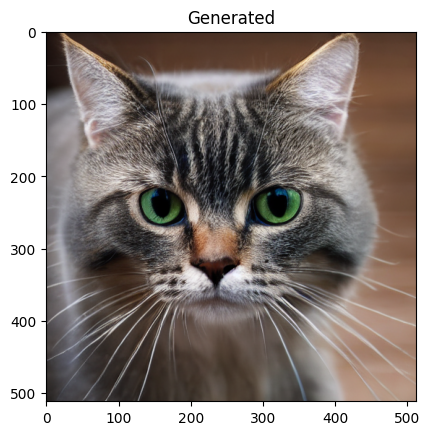

  0%|          | 0/50 [00:00<?, ?it/s]

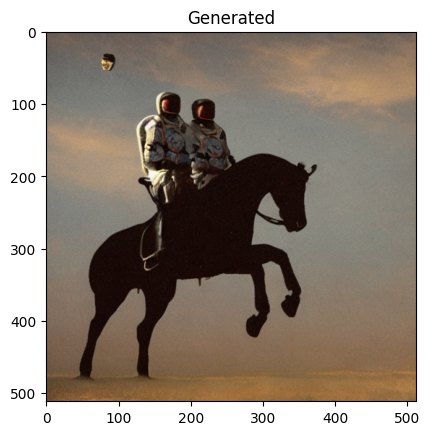

  0%|          | 0/50 [00:00<?, ?it/s]

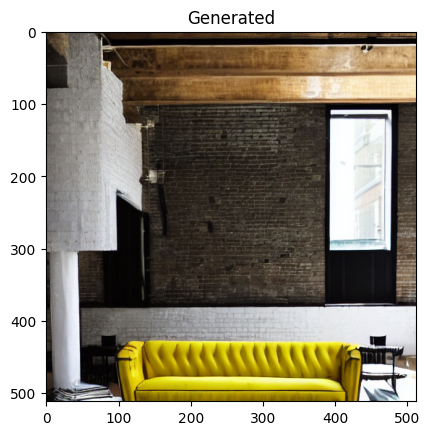

  0%|          | 0/50 [00:00<?, ?it/s]

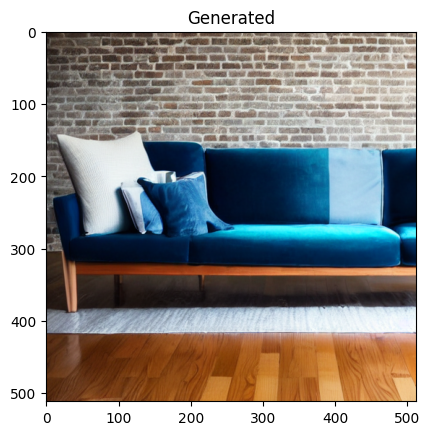

  0%|          | 0/50 [00:00<?, ?it/s]

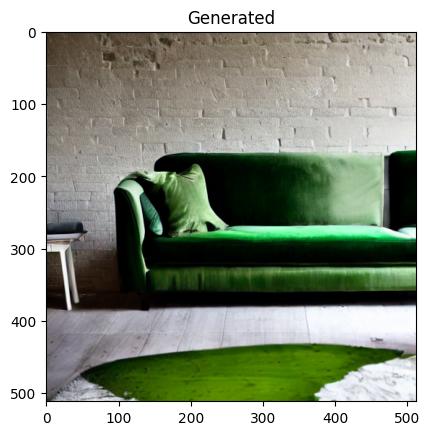

In [8]:
# image generation
sofa_img = utils.get_image_from_url('https://images.pexels.com/photos/1866149/pexels-photo-1866149.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1')

# Generate for a few types of text prompts and image + text prompts.
for prompt in [
    ['a picture of a cat'],
    ['an astronaut riding a horse on mars'],
    [sofa_img, 'a picture of this but in yellow'],
    [sofa_img, 'a picture of this but in blue'],
    [sofa_img, 'a picture of this but in green'],
]:
    g_cuda = torch.Generator(device='cuda').manual_seed(1337)
    return_outputs = model.generate_for_images_and_texts(
        prompt, num_words=2, ret_scale_factor=100.0, generator=g_cuda)

    # Show either the generated or retrieved image, depending on the decision model outputs.
    if return_outputs[1]['decision'][0] == 'gen':
        plt.imshow(return_outputs[1]['gen'][0][0])
        plt.title('Generated')
    else:
        plt.imshow(return_outputs[1]['ret'][0][0].resize((512, 512)))
        plt.title(f"Retrieved")
    plt.show()

In [9]:
# multimodal dialogue
## function
def generate_dialogue(prompts: list, system_message: str = None, num_words: int = 32,
                      sf: float = 1.0, temperature: float = 0.0, top_p: float = 1.0,
                      divider_count: int = 40):
    g_cuda = torch.Generator(device='cuda').manual_seed(1337)

    full_outputs = []
    if system_message:
        print("Adding system message")
        full_inputs = [system_message]
    else:
        full_inputs = []

    for prompt_idx, prompt in notebook.tqdm(enumerate(prompts), total=len(prompts)):
        formatted_prompt = []
        for p in prompt:
            if type(p) == Image.Image:
                full_inputs.append(p)
                formatted_prompt.append(p)
            elif type(p) == str:
                full_inputs.append(f'Q: {p}\nA:')
                formatted_prompt.append(f'User: {p}')
        formatted_prompt.append('=' * divider_count)  # Add divider

        return_outputs = model.generate_for_images_and_texts(
            full_inputs, num_words=num_words, ret_scale_factor=sf,
            generator=g_cuda, temperature=temperature, top_p=top_p)

        # Add outputs
        output_text = return_outputs[0].replace('[IMG0] [IMG1] [IMG2] [IMG3] [IMG4] [IMG5] [IMG6] [IMG7]', '')
        full_inputs.append(output_text + '\n')

        formatted_return_outputs = []
        for p in return_outputs:
            if type(p) == str:
                p_formatted = p.replace('[IMG0] [IMG1] [IMG2] [IMG3] [IMG4] [IMG5] [IMG6] [IMG7]', '')
                formatted_return_outputs.append(f'GILL: {p_formatted}')
            else:
                formatted_return_outputs.append(p)
        formatted_return_outputs.append('=' * divider_count)  # Add divider

        full_outputs.extend(formatted_prompt + formatted_return_outputs)

    return full_outputs


def display_conversation(full_outputs):
    # Display conversation.
    for p in full_outputs:
        if type(p) == Image.Image:
            plt.figure(figsize=(4, 4))
            plt.imshow(p)
            plt.show()
        elif type(p) == str:
            print(p)
        elif type(p) == dict:
            # Decide whether to retrieve or generate
            decision_probs = [f'{s:.3f}' for s in p['decision'][1]]
            if p['decision'][0] == 'gen':
                gen_img = p['gen'][0][0].resize((512, 512))
                # Generate
                plt.figure(figsize=(4, 4))
                plt.imshow(gen_img)
                plt.title(f'GENERATED (p={decision_probs})')
            else:
                ret_img = p['ret'][0][0].resize((512, 512))
                # Retrieve
                plt.figure(figsize=(4, 4))
                plt.imshow(ret_img)
                plt.title(f'RETRIEVED (p={decision_probs})')
            plt.show()
        else:
            raise NotImplementedError(p)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

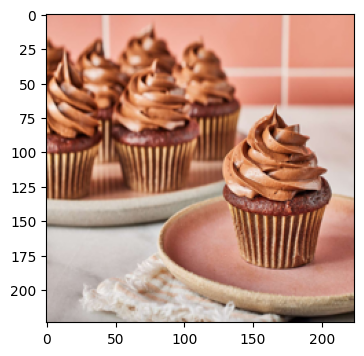

User: How should I publicise these at the market?
GILL:  I think it's a good idea to have a sign that says "free cupcakes ". 


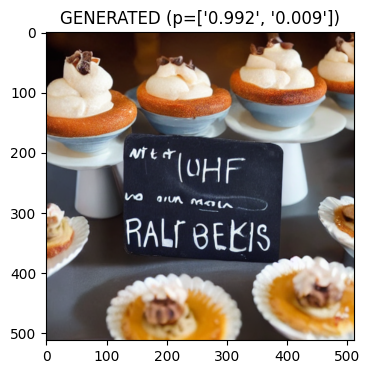

In [10]:
# multimodal dialogue
## apply
prompts = [
    [
        utils.get_image_from_url('https://www.allrecipes.com/thmb/riDYvmalWk8QgJDBT_pZRkpfpR0=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/17377-chocolate-cupcakes-DDMFS-4x3-622a7a66fcd84692947794ed385dc991.jpg'),
        'How should I publicise these at the market?'
    ],
]

full_outputs = generate_dialogue(prompts, num_words=num_words, sf=sf, temperature=temperature, top_p=top_p)
display_conversation(full_outputs)

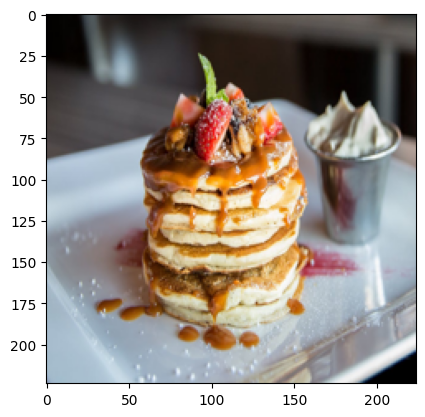

 a stack of pancakes with maple syrup and strawberries.


In [11]:
# image2text
pancakes_img = utils.get_image_from_url('https://images.pexels.com/photos/376464/pexels-photo-376464.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1')
prompts = [
    pancakes_img,
    'A picture of'
]

plt.imshow(pancakes_img)
plt.show()

return_outputs = model.generate_for_images_and_texts(prompts, num_words=16, min_word_tokens=16)
print(return_outputs[0])